#### Выбор метрик

Для принятия решения буду ориентироваться на несколько метрик.

**Целевая метрика:**  
* частота исходов значений в колонке is_match для каждой группы, соотношение данных значений  

**Прокси метрика:**  
* среднее количество активностей на пользователя  

**Группа 0 (контрольная группа)** — приложение со старым алгоритмом  
**Группа 1 (экспериментальная группа)** —  приложение с новым алгоритмом

### Проведу EDA
Импортирую необходимые для работы библиотеки, считаю данные, сформирую датафреймы

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns

##### dating_data_df — хранит логи взаимодействия пользователей друг с другом  
- **user_id_1**	— уникальный id пользователя 1;  
- **user_id_2** — уникальный id пользователя 2;  
- **group** — номер группы к которой относятся пользователи;
- **is_match** — хранит значение о том случился ли мэтч у пользователей (0 — мэтч не случился, 1 — мэтч случился).

In [2]:
dating_data_df = pd.read_csv("./data/dating_data.csv")

In [3]:
# Посмотрю на первые 5 строк DF
print(dating_data_df.head())
print()
print(f'\033[1mdating_data_df состоит из {dating_data_df.shape[1]} колонок и {dating_data_df.shape[0]} строк \033[0m')

   user_id_1  user_id_2  group  is_match
0         79         91      1         1
1        716        353      1         1
2        423        677      0         0
3        658        165      1         1
4        969        155      0         1

dating_data_df состоит из 4 колонок и 14514 строк 


In [4]:
# Посмотрю на тип данных
dating_data_df.info()
print()
print('\033[1mВсе колонки имеют корректный тип данных \033[0m')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB

Все колонки имеют корректный тип данных 


In [5]:
# Посмотрю есть ли пропущенные значения в таблице
number_of_passes = dating_data_df.isnull().sum().sum()

if number_of_passes == 0:
    print('\033[1mПропущенные значения отсутствуют \033[0m')
else:
    print('\033[1mПрисутствуют пропущенные значения! \033[0m')
    print(dating_data_df.isnull().sum())

Пропущенные значения отсутствуют 


In [6]:
# Проверю строки датафрейма на дубли
num_duplicates = dating_data_df.duplicated().sum()
print(f"\033[1mКоличество дублирующихся строк: {num_duplicates} \033[0m")

Количество дублирующихся строк: 0 


In [7]:
# Проверю, что в данных нет такой ситуации, когда user_id_1 == user_id_2. Если есть, то выведу строки df с пересекающимися user_id
intersection = dating_data_df.user_id_1 == dating_data_df.user_id_2

if (dating_data_df.user_id_1 == dating_data_df.user_id_2).isin([True]).any():
    print('\033[1mНайдены строки в которых user_id_1 совпадает с user_id_2!\033[0m')
    print(dating_data_df[intersection])
else:
    print('\033[1mСтроки в которых user_id_1 совпадает с user_id_2 не найдены\033[0m')

Строки в которых user_id_1 совпадает с user_id_2 не найдены


In [8]:
# Посмотрю есть ли пользователи, которые относятся больше чем к одной группе
# Создам датафреймы в которых будут храниться сгруппированные значения колонок user_id_1 и user_id_2 со списоками уникальных номеров групп каждого пользователя
df_1 = dating_data_df.groupby(['user_id_1'], as_index=False) \
                     .agg({'group':'unique'})
df_2 = dating_data_df.groupby(['user_id_2'], as_index=False) \
                     .agg({'group':'unique'})

# Объединю df используя параметр how='outer'
df_merge = pd.merge(df_1, df_2, left_on=['user_id_1'], right_on=['user_id_2'], how='outer', suffixes=('_df1', '_df2'))

# Для тех значений у которых не нашлось пары при объединении, заменю NaN значения на значения из колонки другой группы
df_merge['group_df1'].fillna(df_merge['group_df2'], inplace=True)
df_merge['group_df2'].fillna(df_merge['group_df1'], inplace=True)
df_merge['user_id_1'].fillna(df_merge['user_id_2'], inplace=True)
df_merge['user_id_2'].fillna(df_merge['user_id_1'], inplace=True)

# Поменяю тип данных в колонке
df_merge['user_id_1'] = df_merge.loc[:, ['user_id_1']].astype(int)

# Выведу только нужные колонки, переименую колонку user_id_1
df_merge = df_merge.loc[:, ['user_id_1', 'group_df1', 'group_df2']].rename(columns=({'user_id_1':'user_id'}))

# Создам булеву маску для df_1 и df_2. True - в списке групп пользователя больше одной группы
mask_df1 = df_merge['group_df1'].map(lambda x: len(x) > 1)
mask_df2 = df_merge['group_df2'].map(lambda x: len(x) > 1)

# Если количество значеий в списке групп пользователя (group_df1 или group_df2) больше чем 1, то вывести True
mask_result = (mask_df1 | mask_df2)

if df_merge[mask_result].shape[0] == 0:
    print("\033[1mВсе пользователи состоят только в одной группе\033[0m")
else:
    print("\033[1mЕсть пользователи, которые состоят в нескольких группах!\033[0m")
    print(df_merge[mask_result])

Все пользователи состоят только в одной группе


In [9]:
# Посмотрю на количество уникальных пользователей в каждой группе
number_user_id = df_merge[['user_id', 'group_df1']].explode('group_df1') \
                                                   .groupby(['group_df1'], as_index=False) \
                                                   .agg({'user_id': 'nunique'}) \
                                                   .rename(columns=({'user_id': 'amount', 'group_df1': 'group'}))

delta_percent = (number_user_id['amount'].max() / number_user_id['amount'].min()) * 100 - 100
print(number_user_id)
print()
print(f"\033[1mРазница между группами небольшая {delta_percent:.2f} %, группы можно считать равными по количеству уникальных пользователей. \033[0m")

  group  amount
0     0     501
1     1     499

Разница между группами небольшая 0.40 %, группы можно считать равными по количеству уникальных пользователей. 


In [10]:
# Посмотрю на количество уникальных пользователей в user_id_1 и user_id_2
user_id_1_uniq = dating_data_df.user_id_1.unique()
user_id_2_uniq = dating_data_df.user_id_2.unique()
len(user_id_1_uniq), len(user_id_2_uniq)

(1000, 1000)

In [11]:
# Сравниваю элементы массивов
if sorted(user_id_1_uniq) == sorted(user_id_2_uniq):
    print('\033[1mМассивы равны. Из этого делаю вывод, что в колонках user_id_1 и user_id_2 находятся одни и те же пользователи из которых составлены пары (непересекающиеся сами с собой).\nПолучается, что всего в эксперименте принимало участие 1000 пользователей.\033[0m')
else:
    print('\033[1mМассивы неравны\033[0m')

Массивы равны. Из этого делаю вывод, что в колонках user_id_1 и user_id_2 находятся одни и те же пользователи из которых составлены пары (непересекающиеся сами с собой).
Получается, что всего в эксперименте принимало участие 1000 пользователей.


In [12]:
# Склею два df
dating_data_df_user_1 = dating_data_df[['user_id_1', 'is_match', 'group']].rename(columns={'user_id_1': 'user_id'})
dating_data_df_user_2 = dating_data_df[['user_id_2', 'is_match', 'group']].rename(columns={'user_id_2': 'user_id'})
concat_df = pd.concat([dating_data_df_user_1, dating_data_df_user_2]).reset_index(drop=True)
concat_df.head()

,user_id,is_match,group
0,79,1,1
1,716,1,1
2,423,0,0
3,658,1,1
4,969,1,0


In [13]:
# Посмотрю на количество активностей для каждого пользователя, к какой группе относится пользователь, количество состоявшихся и несостоявшихся мэтчей
user_statistics_df = concat_df.groupby(['user_id', 'group'], as_index=False) \
                              .agg({'is_match': ['count', 'sum', lambda x: (x.count() - x.sum())]}) \
                              .rename(columns={'count': 'activity_total', 'sum': 'match_total', '<lambda_0>': 'mismatch_total'})
# Удалю 0 уровень в имени колонок
user_statistics_df.columns = user_statistics_df.columns.droplevel(0)
# Переименую колонки
user_statistics_df.columns = ['user_id', 'group', 'activity_total', 'match_total', 'mismatch_total']

print(user_statistics_df.head())
print('\033[1m\nuser_id — id пользователя\ngroup — группа пользователя\nactivity_total — количество активностей\nmatch_total — количество мэтчей\nmismatch_total — количество несостоявшихся мэтчей\033[0m')

   user_id  group  activity_total  match_total  mismatch_total
0        1      1              37           16              21
1        2      1              39           16              23
2        3      1              25            8              17
3        4      0              17            3              14
4        5      1              34           18              16

user_id — id пользователя
group — группа пользователя
activity_total — количество активностей
match_total — количество мэтчей
mismatch_total — количество несостоявшихся мэтчей


In [14]:
# Статистика по средним значениям каждой группы
group_statistics_avg_df = user_statistics_df.groupby(['group'], as_index=False) \
                                            .agg({'activity_total': 'mean', 'match_total': 'mean', 'mismatch_total': 'mean'}).round(2) \
                                            .rename(columns=({'activity_total': 'activity_total_avg', 'match_total': 'match_total_avg', 'mismatch_total': 'mismatch_total_avg'}))
group_statistics_avg_df

,group,activity_total_avg,match_total_avg,mismatch_total_avg
0,0,19.13,3.73,15.4
1,1,38.97,15.67,23.3


Если смотреть на соотношение значений в группах, то пулучаем следующее:  
- для группы 0, соотношение **match_total_avg** к **mismatch_total_avg** составляет 24,2 %  
- для группы 1, соотношение **match_total_avg** к **mismatch_total_avg** составляет 67,3 %

Если смотреть на то, на сколько средние значения в группе 1 больше чем в группе 0, то получается следующее:
- **activity_total_avg** больше на 103,7%
- **match_total_avg** больше на 320,1%
- **mismatch_total_avg** больше на 51,3%

# Целевая метрика

## Визуальная проверка

### Таблица сопряженности (наблюдаемые/ожидаемые значения)

In [15]:
# Для каждой группы посчитаю наблюдаемые значения, ожидаемые и статистику
expected, observed, stat = pg.chi2_independence(concat_df, x='group', y='is_match', correction=False)

In [16]:
# Наблюдаемые значения
observed

is_match,0,1
group,,
0,7716,1868
1,11626,7818


In [17]:
# Ожидаемые значения
expected

is_match,0,1
group,,
0,6386.031694,3197.968306
1,12955.968306,6488.031694


### Гистограмма, соотношение несостоявшихся / состоявшихся мэтчей

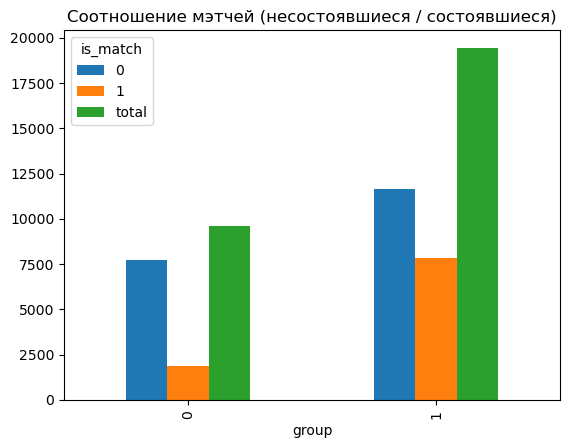

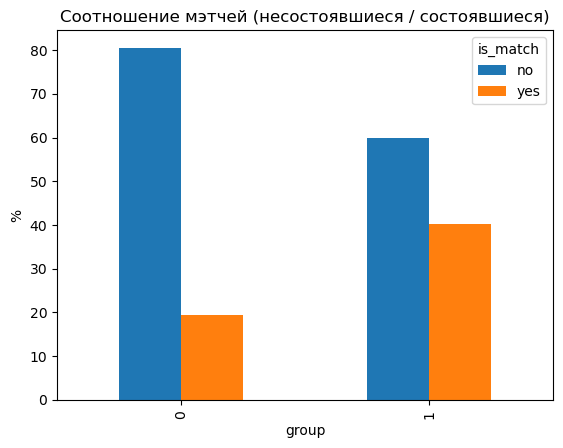

In [18]:
# Соотношение мэтчей (несостоявшиеся / состоявшиеся)
observed['total'] = observed[0] + observed[1]
observed[[0, 1, 'total']].plot.bar()
plt.title('Соотношение мэтчей (несостоявшиеся / состоявшиеся)')

# Соотношение мэтчей в процентах (несостоявшиеся / состоявшиеся)
observed['no'] = (observed[0] / observed['total']).mul(100).round(2)
observed['yes'] = (observed[1] / observed['total']).mul(100).round(2)
observed[['no', 'yes']].plot.bar()
plt.ylabel('%')
plt.title('Соотношение мэтчей (несостоявшиеся / состоявшиеся)')

plt.show()

### Вывод по визуальному анализу

По таблице сопряжённости и графикам видно, что в экспериментальной группе соотношение состоявшихся мэтчей к несостоявшимся больше. При помощи статистических тестов определю статистически значимы эти различия или нет. Так как значения в колонке is_match это категориальная величина (0 и 1), то проверять значения на нормальность распределения не имеет смысла. Для проверки статистической значимости результатов воспользуюсь критерием хи-квадрат Пирсона.

## Хи-квадрат Пирсона
**Тип данных:** качественный, бинарный  
**Целевая метрика:** частота исходов значений в колонке is_match для каждой группы 

**<u>Определю гипотезы:</u>**  
* H0 - между контрольной и экспериментальной группой нет никакой статистически значимой разницы в частоте исходов значений<br>
* H1 - наблюдаемый эффект это результат внедрения в приложение нового алгоритма, разница статистически значима

Проверяю значимость полученной статистики хи-квадрат с помощью таблицы критических значений.<br>
Значение критической статистики для уровня значимости [0.05](https://math.semestr.ru/group/xixi.php#:~:text=5.0-,3.8,-0.0039) и степени свободы равной 1 = 3.8

In [19]:
# Для простоты интерпретации добавляю колонку в которой сравнивается alpha (0.05) и p-value
stat['p<alpha'] = stat['pval'] < 0.05

In [20]:
# Статистика
stat

,test,lambda,chi2,dof,pval,cramer,power,p<alpha
0,pearson,1.000000,1239.240692,1.0,1.808487e-271,0.206619,1.0,True
1,cressie-read,0.666667,1259.033883,1.0,9.033232e-276,0.208262,1.0,True
2,log-likelihood,0.000000,1307.975970,1.0,2.088986e-286,0.212271,1.0,True
3,freeman-tukey,-0.500000,1354.034898,1.0,2.045798e-296,0.215976,1.0,True
4,mod-log-likelihood,-1.000000,1409.448665,1.0,1.858742e-308,0.220352,1.0,True
5,neyman,-2.000000,1554.535690,1.0,0.000000e+00,0.231415,1.0,True


### Вывод
Критическое значение (3.8) < полученной статистики (1239.240692), p-value < 0.05. Это означает, что у меня не имеется достаточных оснований, что бы принять H0.  
**Принимаю H1**, в частоте исходов значений из колонки **is_match** между группой 0 и 1 имеются статистически значимые различия.

# Прокси метрика

## Визуальная проверка

### Средняя активность в разрезе по пользователям в каждой группе

In [21]:
activity_avg_df = user_statistics_df.groupby(['group'], as_index=False) \
                                    .agg({'activity_total': 'mean'}) \
                                    .rename(columns=({'activity_total': 'activity_avg'}))
delta_percent = (activity_avg_df['activity_avg'].max() / activity_avg_df['activity_avg'].min()) * 100 - 100
print(activity_avg_df)
print()
print(f"\033[1mЕсть различия. В экспериментальной группе среднее количество активностей на пользователя больше на {delta_percent:.2f} % \033[0m")

   group  activity_avg
0      0     19.129741
1      1     38.965932

Есть различия. В экспериментальной группе среднее количество активностей на пользователя больше на 103.69 % 


### kdeplot, плотность распределения значений в каждой группе

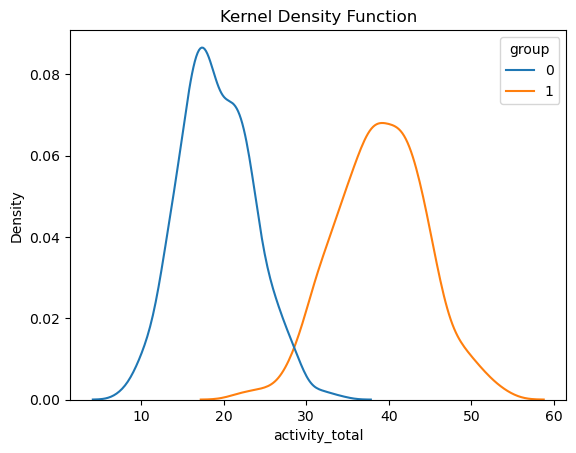

In [22]:
sns.kdeplot(x='activity_total', data=user_statistics_df, hue='group', common_norm=False);
plt.title("Kernel Density Function");
plt.show()

### boxplot, распределение количества активностей на пользователя

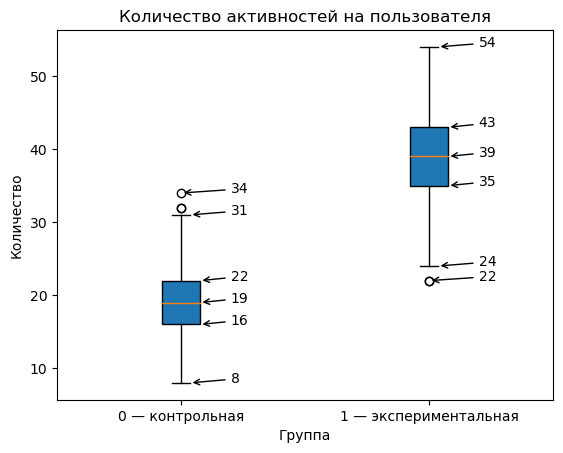

Видно, что в экспериментальной группе количество активностей на пользователя существенно больше чем в контрольной группе. 


In [23]:
# Разделю на отдельные группы
data0 = user_statistics_df[user_statistics_df.group == 0]['activity_total'].values  # контрольная группа
data1 = user_statistics_df[user_statistics_df.group == 1]['activity_total'].values  # экспериментальная группа

# Создание боксплота
fig, ax = plt.subplots()
bp = ax.boxplot([data0, data1], patch_artist=True)

# Добавлю название гистограмме и ее осям
plt.title('Количество активностей на пользователя')
plt.xlabel('Группа')
plt.ylabel('Количество')

# Подпись значений квартилей, усов и выбросов для каждой группы
for i, group_data in enumerate([data0, data1], start=0):
    
    quartiles = np.percentile(group_data, [25, 50, 75])
    
    # Подписи квартилей (25, 50, 75)
    for q in quartiles:
        ax.annotate(f'{q:.0f}', xy=(i + 1.075, q), xytext=(i + 1.2, q),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')

    
    # Максимальное и минимальное значение в группе
    max_val = np.max(group_data)
    min_val = np.min(group_data)

    # Значения усов (верхний и нижний)
    lower_whiskers =  bp['whiskers'][2 * i].get_ydata()[1]
    upper_whiskers = bp['whiskers'][2 * i + 1].get_ydata()[1]  
    
    # Подписи выбросов (максимальных и минимальных)
    if max_val != upper_whiskers:
        ax.annotate(f'{max_val:.0f}', xy=(i + 1, max_val), xytext=(i + 1.2, max_val),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')
    if min_val != lower_whiskers:
        ax.annotate(f'{min_val:.0f}', xy=(i + 1, min_val), xytext=(i + 1.2, min_val),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    fontsize=10, color='black')    
   
    # Подписи усов (верхний и нижний)
    ax.annotate(f'{lower_whiskers:.0f}', xy=(i + 1.035, lower_whiskers), xytext=(i + 1.2, lower_whiskers),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=10, color='black')
    ax.annotate(f'{upper_whiskers:.0f}', xy=(i + 1.035, upper_whiskers), xytext=(i + 1.2, upper_whiskers),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=10, color='black')

# Настройка меток осей
ax.set_xticklabels(['0 — контрольная', '1 — экспериментальная'])
plt.show()

print("\033[1mВидно, что в экспериментальной группе количество активностей на пользователя существенно больше чем в контрольной группе. \033[0m")

## Тесты

### Проверка нормальности распределения данных при помощи **pg.normality**  

**<u>Определю гипотезы:</u>**  
* H0: значения из колонки activity_total распределены нормально  
* H1: распределение значений из колонки activity_total является ненормальным

In [24]:
pg.normality(data=user_statistics_df, dv='activity_total', group='group', method='normaltest')

,W,pval,normal
group,,,
1,0.319658,0.852289,True
0,5.214400,0.073741,True


#### Вывод
Значения p-value в обеих группах больше альфа-уровня (0.05). Это означает то, что у меня имеется достаточно оснований, что бы принять H0.<br>
**Принимаю H0**, распределение значений колонки activity_total является нормальным.

### Проверка данных на нормальность и гомогенность (гомоскедастичность) дисперсии  

Для проверки равенства дисперсий в группах воспользуюсь тестом Левина 

**<u>Определю гипотезы:</u>**  
* H0: дисперсии между группами можно считать однородными
* H1: дисперсии между группами значимо различаются

In [25]:
def check_tail_heaviness(data, alpha=0.05):
    '''
    Функция проверяет тяжесть хвоста
    
    Аргументы
    ----------
    * data: значения которые требуется проверить
    * alpha: альфа-уровнь, по умолчанию равен 0.05
    '''
    ks_stat, ks_p = stats.kstest(data, 'norm')
    if ks_p < alpha:
        print(f'\033[1m Данные имеют тяжелый хвост, p-value: {ks_p} \033[0m')
    else:
        print(f'\033[1m Данные имеют легкий хвост, p-value: {ks_p} \033[0m')
print(check_tail_heaviness.__doc__)


    Функция проверяет тяжесть хвоста
    
    Аргументы
    ----------
    * data: значения которые требуется проверить
    * alpha: альфа-уровнь, по умолчанию равен 0.05
    


In [26]:
# Воспользуюсь функцией check_tail_heaviness для определения типа хвоста (тяжелый/легкий) 
check_tail_heaviness(user_statistics_df['activity_total'])

 Данные имеют тяжелый хвост, p-value: 0.0 


In [27]:
# Сравню дисперсии тестом Левина. Параметр center='trimmed' — рекомендуется для распределений с тяжелыми хвостами
test_stat, pvalue = stats.levene(user_statistics_df[user_statistics_df.group == 0].activity_total, user_statistics_df[user_statistics_df.group == 1].activity_total, center='trimmed')
if pvalue > 0.05:
    print(f"\033[1mСтатистика = {round(test_stat, 2)}, p-value = {pvalue}\033[0m")
else:
    print(f"\033[1mСтатистика = {round(test_stat, 2)}, p-value = {pvalue}\033[0m")

Статистика = 20.52, p-value = 6.710739983967394e-06


#### Вывод  
Значение p-value меньше альфа-уровня (0.05). Это означает то, что у меня не имеется достаточно оснований, что бы принять H0.<br>
**Принимаю H1**, дисперсии не равны.

### Вовод по результатам тестов и визуальному анализу  
Исходя из предварительного анализа, результатов теста на нормальность и гомогенность дисперсий можно использовать t-test с поправкой Уэлча, применяется в случае неравных дисперсий. Особенно поправка важна, если размеры двух выборок сильно различаются. В остальном все как у обычного т-теста — если выборки большие, нормальность становится не так уж важна (в силу разных теорем, в том числе ЦПТ).

## Welch’s t-test
**Тип данных:** количественный, дискретный  
**Целевая метрика:** среднее количество активностей на пользователя  

**<u>Определю гипотезы:</u>**  
* H0 - между контрольной и экспериментальной группой нет никакой статистически значимой разницы в среднем количестве активностей на пользователя<br>
* H1 - наблюдаемый эффект это результат внедрения в приложение нового алгоритма, разница статистически значима

In [28]:
stats.ttest_ind(user_statistics_df[user_statistics_df.group == 0].activity_total, user_statistics_df[user_statistics_df.group == 1].activity_total, equal_var = False)

TtestResult(statistic=-62.81020734004636, pvalue=0.0, df=952.8731865785683)

### Вывод  
p-value меньше альфа-уровня (0.05). Это означает то, что у меня имеется достаточно оснований, что бы отвергнуть H0 и **принять H1**.  
Делаю вывод, что разница между средним количеством активностей на пользователя в каждой группе статистически значима и является результатом внедрения нового алгоритма поиска анкет.

# Заключение  
После анализа и проведенных статистических тестов, можно сделать вывод, что в результате внедрения нового алгоритма поиска анкет в экспериментальной группе повысилось количество активностей на пользователя и частота случившихся мэтчей. Можно раскатывать новый алгоритм поиска анкет на всех пользователей.